In [473]:
# 导入各种库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import statsmodels

In [474]:
# 读取数据
train_data= pd.read_csv('zhengqi_train.txt',sep='\t')
test_data= pd.read_csv('zhengqi_test.txt',sep='\t')

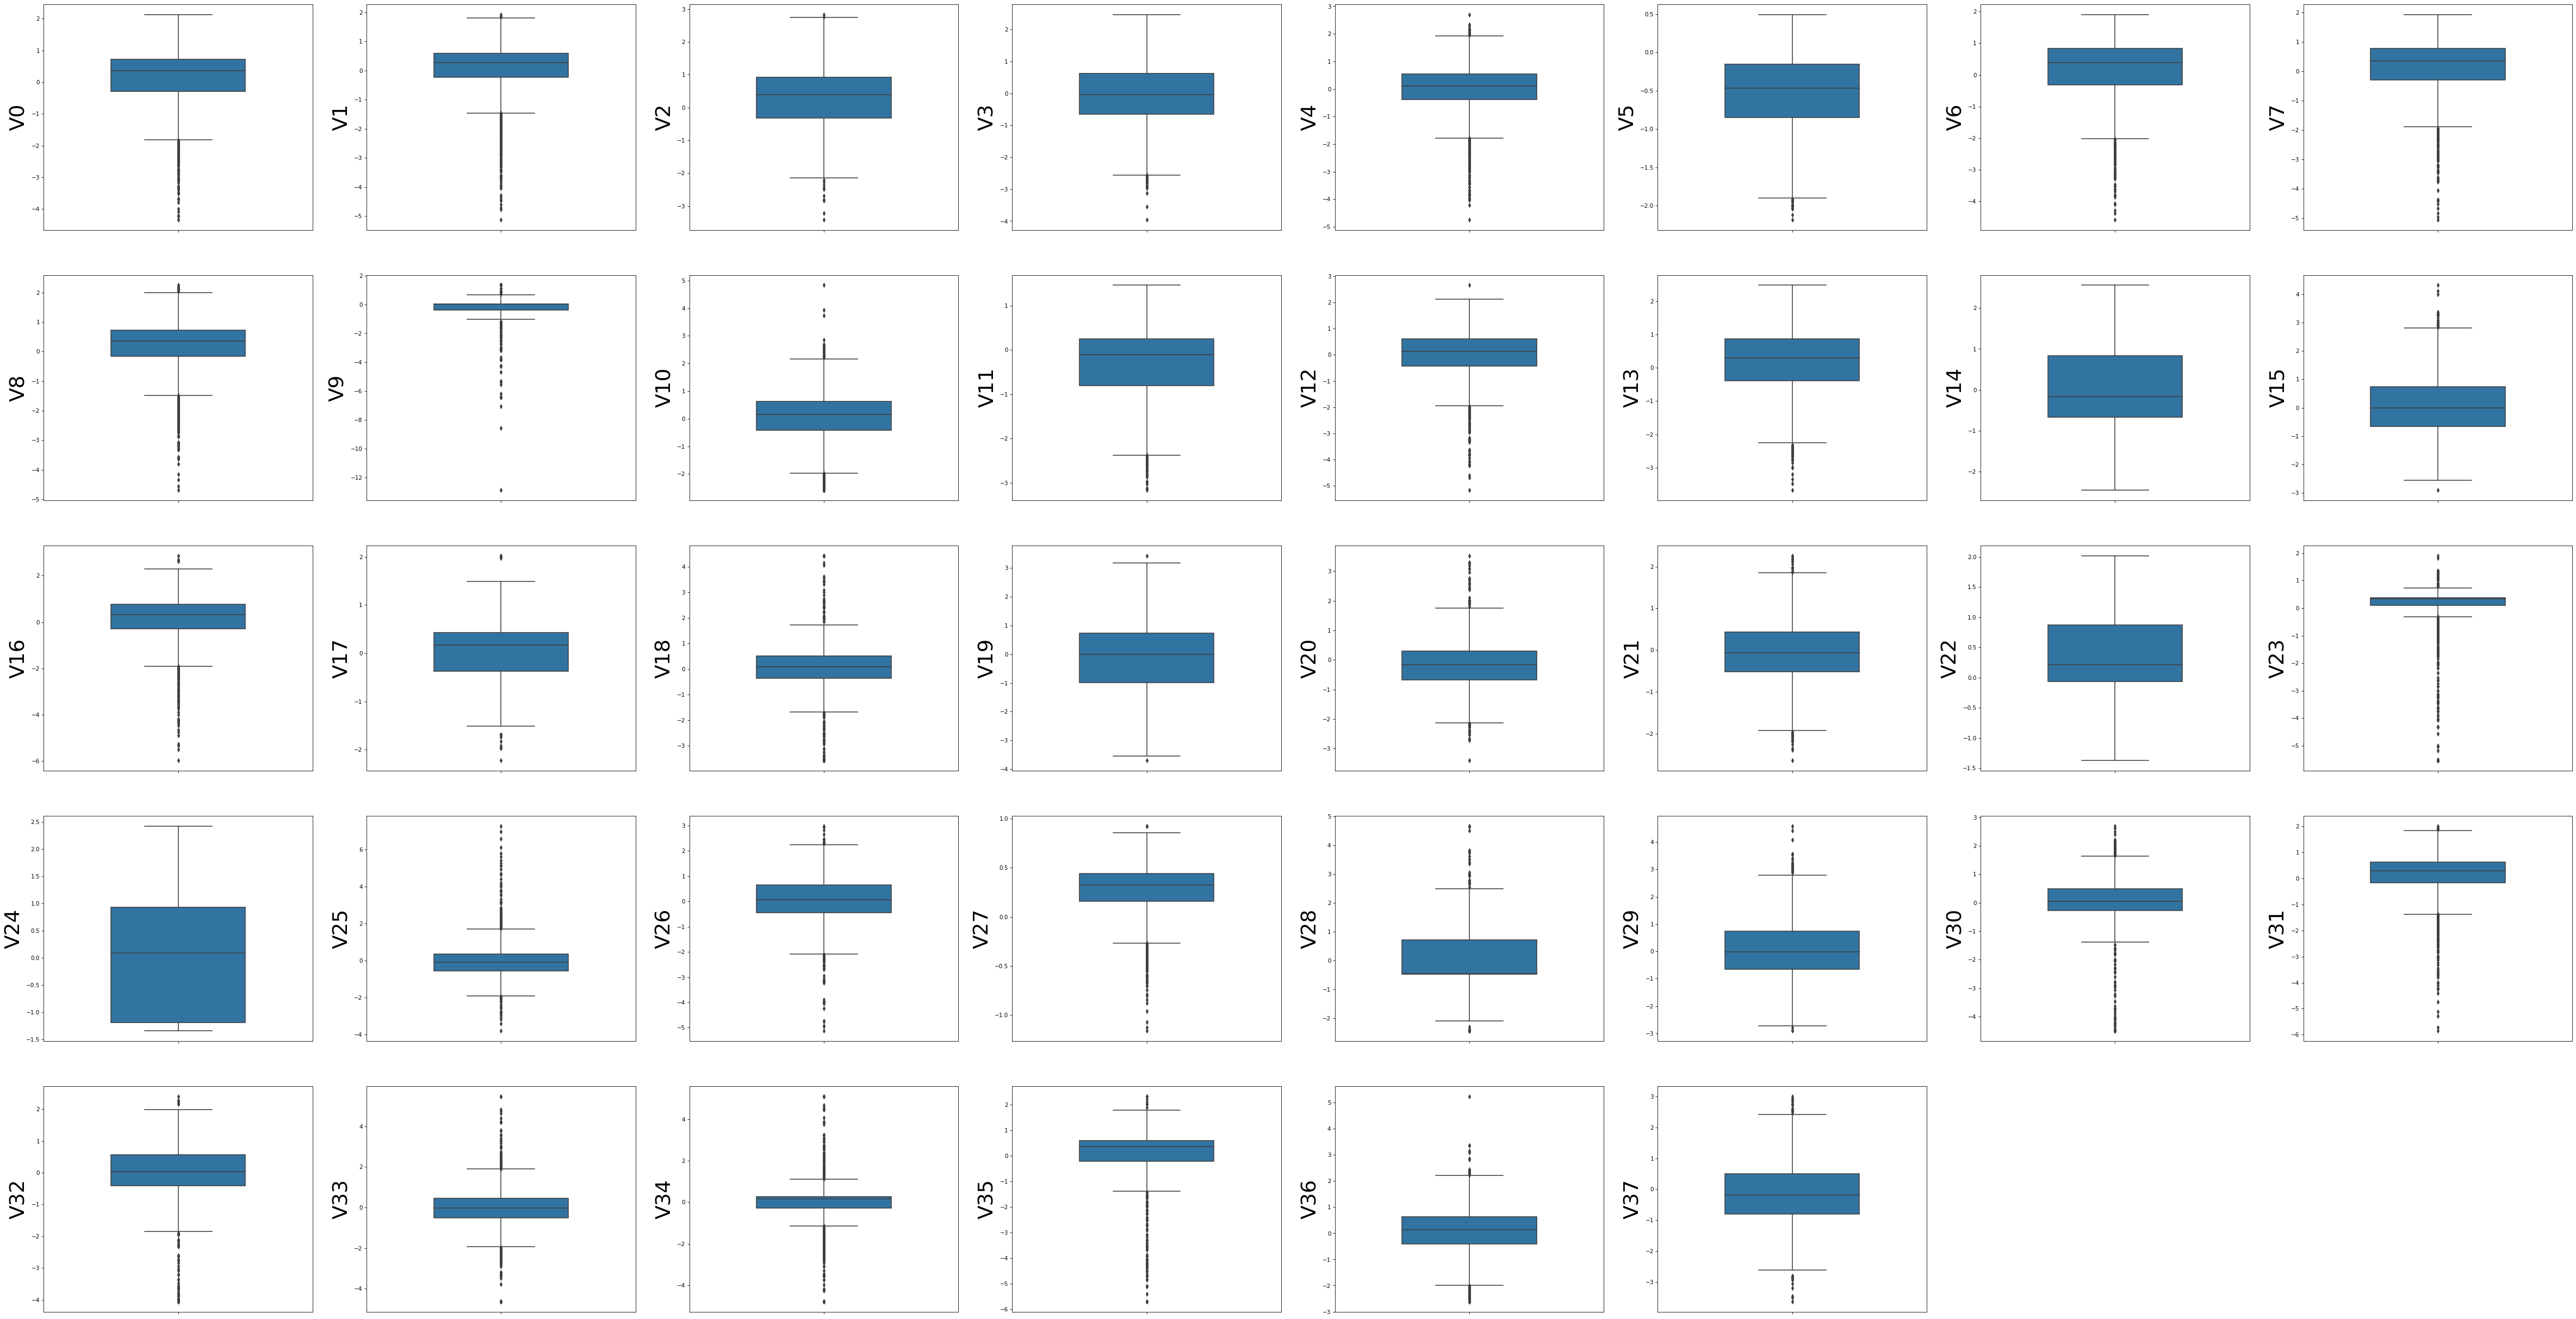

In [475]:
# 画箱型图，观察是否有异常值

col=train_data.columns.tolist()[:39]
fig=plt.figure(figsize=(80,60),dpi=75)
for i in range(38):
    plt.subplot(7,8,i+1)
    sns.boxplot(train_data[col[i]],orient='v',width=0.5)
    plt.ylabel(col[i],fontsize=36)
plt.show()

# 每个特征都有异常值，接下来删除异常数据 

R2= 0.9983706501520052
mse= 0.0015769715398205853
------------------------------------------
mean of residuals:  -1.4189583223590725e-05
std of residuals:  0.039717975405626986
------------------------------------------
166 outliers: 
[112, 143, 155, 164, 172, 178, 197, 204, 206, 210, 244, 261, 266, 272, 292, 293, 303, 339, 398, 482, 487, 489, 494, 504, 563, 564, 573, 574, 576, 583, 608, 620, 621, 623, 624, 642, 652, 658, 676, 678, 683, 715, 725, 738, 769, 776, 805, 808, 809, 845, 847, 881, 892, 893, 919, 925, 959, 993, 996, 1026, 1052, 1085, 1104, 1145, 1160, 1164, 1187, 1197, 1209, 1214, 1223, 1226, 1228, 1282, 1287, 1309, 1315, 1321, 1326, 1357, 1359, 1372, 1433, 1452, 1469, 1488, 1491, 1493, 1497, 1504, 1520, 1525, 1526, 1527, 1592, 1613, 1614, 1620, 1645, 1669, 1704, 1707, 1783, 1838, 1855, 1857, 1917, 1950, 1951, 1953, 1954, 1956, 1959, 1960, 1967, 1972, 1973, 1974, 1977, 1981, 1986, 2003, 2011, 2025, 2130, 2137, 2169, 2172, 2182, 2187, 2189, 2243, 2268, 2274, 2290, 2303, 2323, 2

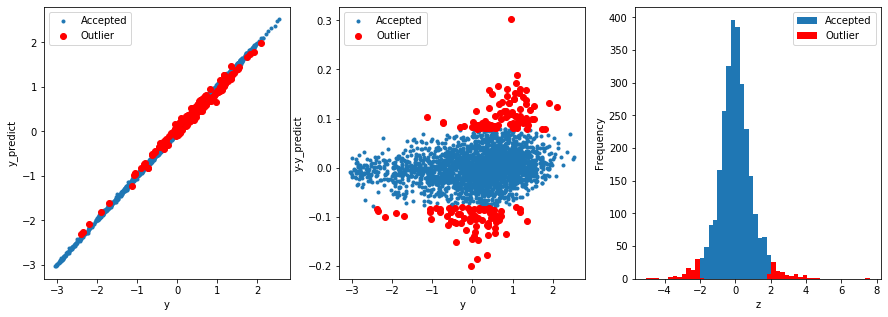

In [476]:
# 异常值删除函数
def find_outliers(model,X,y,sigma=2):
    # 用模型预测y的值
    try:
        y_predict=pd.Series(model.predict(X),index=y.index)
    # 如果预测失败，先用模型拟合
    except:
        model.fit(X,y)
        y_predict=pd.Series(model.predict(X),index=y.index)
    
    # 计算模型预测值与实际值之间的差异
    resid=y-y_predict
    mean_resid=resid.mean()
    std_resid=resid.std()

    # 计算超出范围的z，以及z的索引
    z=(resid-mean_resid)/std_resid
    outliers=z[abs(z)>sigma].index

    # 输出计算结果
    print('R2=',model.score(X,y))
    print('mse=',mean_squared_error(y,y_predict))
    print('------------------------------------------')

    print('mean of residuals: ',mean_resid)
    print('std of residuals: ',std_resid)
    print('------------------------------------------')

    print(len(outliers),'outliers: ')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131=plt.subplot(1,3,1)
    plt.plot(y,y_predict,'.')
    plt.plot(y.loc[outliers],y_predict.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_predict')

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_predict,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_predict.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y-y_predict')

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')

    return outliers

# 通过xgboost回归模型找出异常值
import xgboost as xgb
X_train=train_data.iloc[:,:-1]
y_train=train_data.iloc[:,-1]
outliers=find_outliers(xgb.XGBRegressor(),X_train,y_train)

# 删除异常值
train_data=train_data.drop([num for num in outliers])
X_train=train_data.iloc[:,:-1]
y_train=train_data.iloc[:,-1]

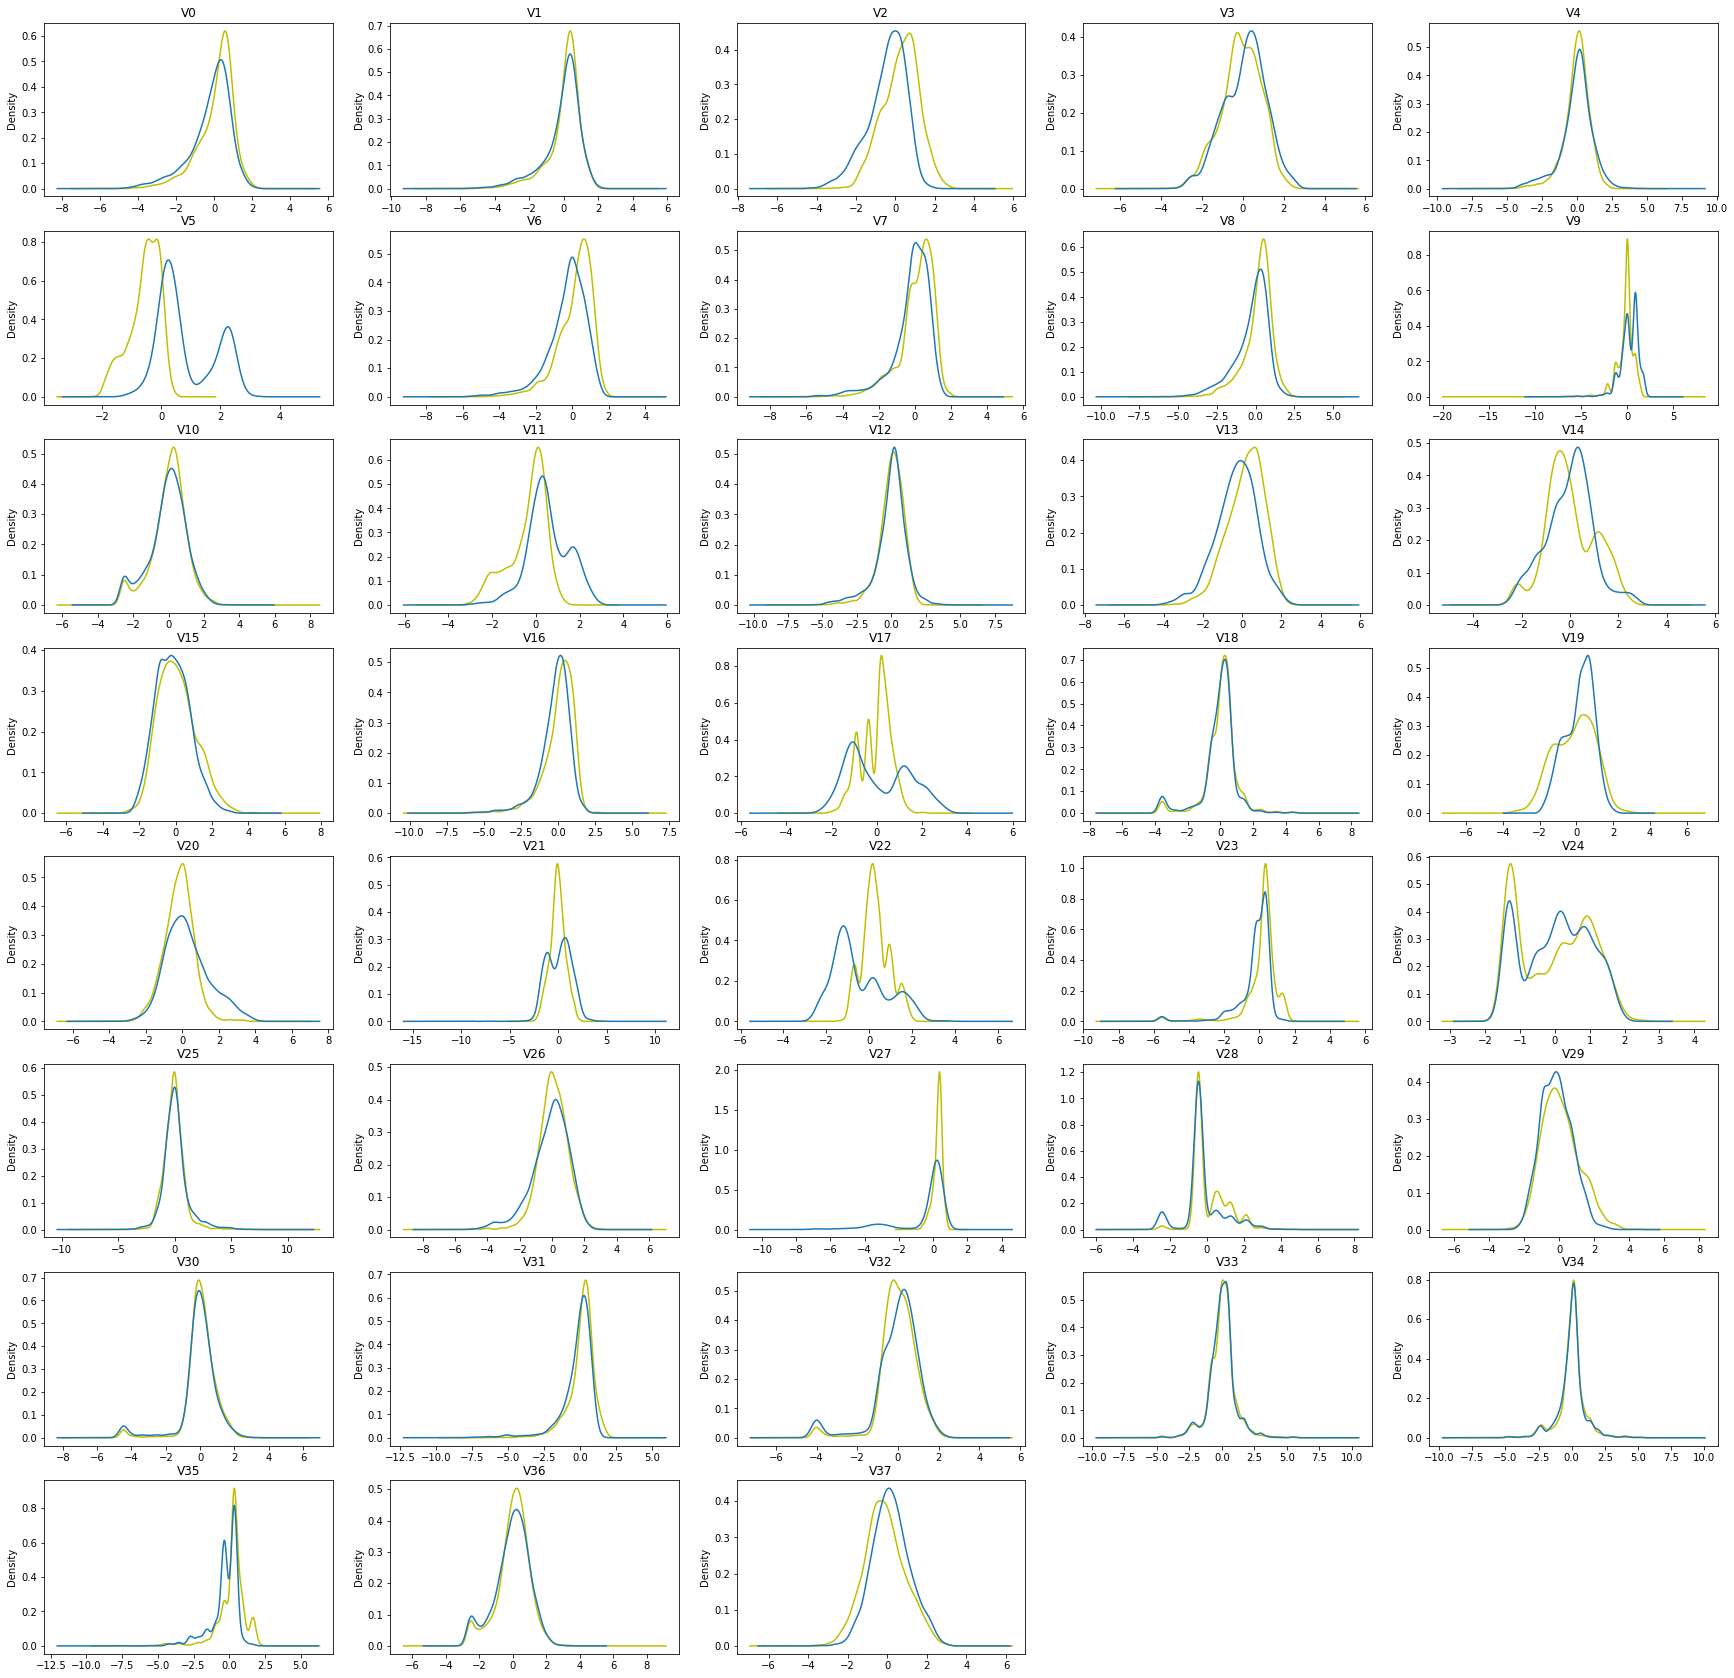

In [477]:
# 观察KDE图，比较两个数据集分布情况

plt.figure(figsize=(30,30))
for i in range(38):
    ax=plt.subplot(8,5,i+1)
    pd.DataFrame(train_data).iloc[:,i].plot(kind='kde',ax=ax,color='y')
    pd.DataFrame(test_data).iloc[:,i].plot(kind='kde',ax=ax)
    ax.set_title(test_data.columns[i])
# 观察后删去分布不同的特征变量

In [478]:
# 删除分布差异较大的属性

train_data=train_data.drop(['V2','V3','V5','V6','V7','V9','V11','V13','V14','V17','V19','V20','V21','V22','V23','V24','V27','V28','V35'], axis=1)
test_data=test_data.drop(['V2','V3','V5','V6','V7','V9','V11','V13','V14','V17','V19','V20','V21','V22','V23','V24','V27','V28','V35'],axis=1)


In [479]:
# 根据相关性删除特征
t=train_data.corr()
drop_columns=t[(np.abs(t['target'])<0.6)].index
train_data.drop(columns=drop_columns,inplace=True)
test_data.drop(columns=drop_columns,inplace=True)

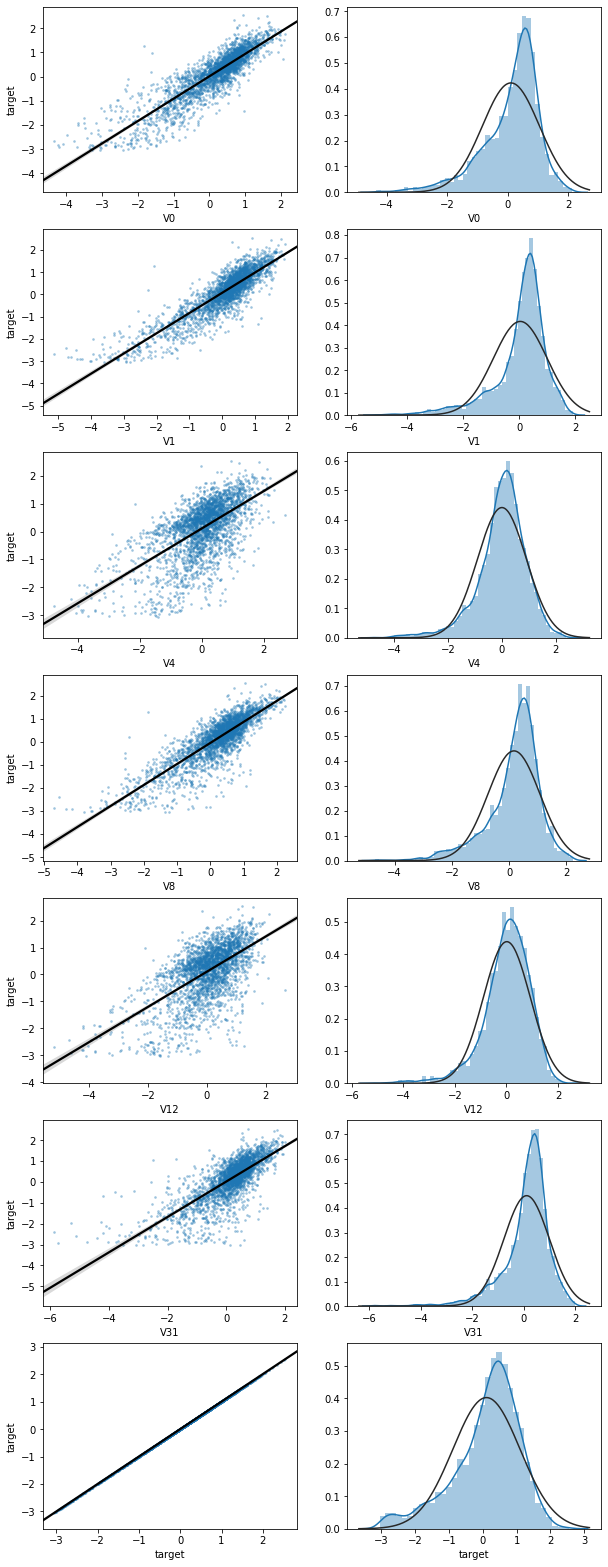

In [480]:

# 可视化线性回归情况
from scipy import stats

fcols = 2
frows = len(train_data.columns)
plt.figure(figsize=(5*fcols,4*frows))

i=0
for col in train_data.columns:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col, y='target', data=train_data, ax=ax, 
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('target')
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(train_data[col].dropna() , fit=stats.norm)
    plt.xlabel(col)


In [481]:
# 归一化所有数据
cols_num=list(train_data.columns)
cols_num.remove('target')
scale_cols= [col for col in cols_num]

def scale_normalization(col):
    return((col-col.min())/(col.max()-col.min()))

train_data[scale_cols]=train_data[scale_cols].apply(scale_normalization)
test_data[scale_cols]=test_data[scale_cols].apply(scale_normalization)

In [482]:
X= train_data.iloc[:,:-1]
y= train_data.iloc[:,-1]

# 交叉验证法
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2)

X_train.reset_index(drop=True)
X_test.reset_index(drop=True)
y_train.reset_index(drop=True)
y_test.reset_index(drop=True)

X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

[13:03:59] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


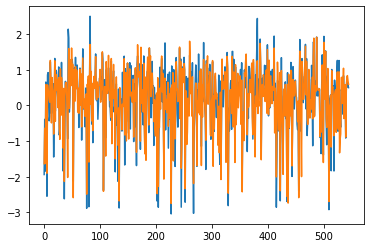

In [483]:
# xgboost算法
from sklearn.metrics import mean_squared_error
import xgboost as xgb

model_xgb=xgb.XGBRegressor(max_depth=4,learning_rate=0.1,n_estimators=100,objective='reg:linear')
model_xgb.fit(X_train,y_train)

predict_xgb=model_xgb.predict(X_test)
mse_xgb=mean_squared_error(y_test,predict_xgb)

plt.plot(y_test)
plt.plot(predict_xgb)

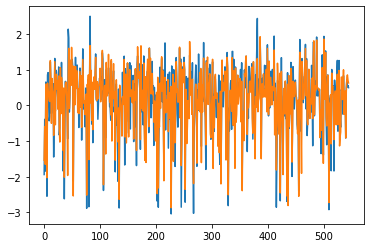

In [484]:
# GBDT Regression
from sklearn.ensemble import GradientBoostingRegressor
model_gbdt=GradientBoostingRegressor(
    loss='ls',
    learning_rate=0.05,
    n_estimators=200,
    subsample=1,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=3,
    alpha=0.8,
    verbose=0,
)

model_gbdt.fit(X_train,y_train)

predict_gbdt=model_gbdt.predict(X_test)

mse_gbdt=mean_squared_error(y_test,predict_gbdt)

plt.plot(y_test)
plt.plot(predict_gbdt)

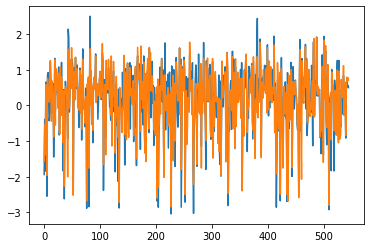

In [485]:
#Random Forests
from sklearn.ensemble import RandomForestRegressor
model_RF=RandomForestRegressor(n_estimators=200,random_state=2)
model_RF.fit(X_train,y_train)
predict_RF=model_RF.predict(X_test)
mse_RF=mean_squared_error(y_test,predict_RF)

plt.plot(y_test)
plt.plot(predict_RF)


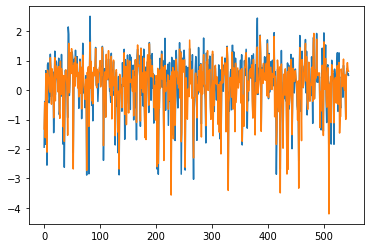

In [486]:
# Bayesian Linear Regression
from sklearn import linear_model
model_BR=linear_model.BayesianRidge()
model_BR.fit(X_train,y_train)

predict_BR=model_BR.predict(X_test)
mse_BR=mean_squared_error(y_test,predict_BR)

plt.plot(y_test)
plt.plot(predict_BR)

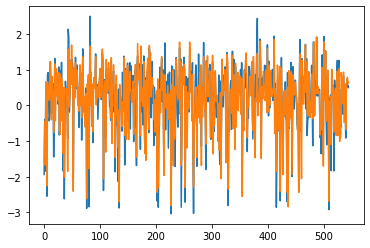

In [487]:
# LightGBM 回归算法
import lightgbm as lgb
model_lgb=lgb.LGBMRegressor()
model_lgb.fit(X_train,y_train)

predict_lgb=model_lgb.predict(X_test)
mse_lgb=mean_squared_error(y_test,predict_lgb)

plt.plot(y_test)
plt.plot(predict_lgb)

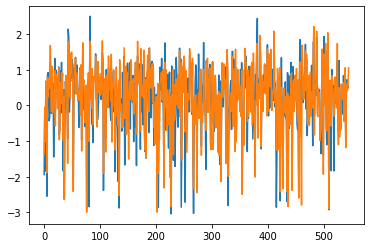

In [488]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
model_DR=DecisionTreeRegressor(splitter='best')
model_DR.fit(X_train,y_train)

predict_DR=model_DR.predict(X_test)
mse_DR=mean_squared_error(y_test,predict_DR)

plt.plot(y_test)
plt.plot(predict_DR)

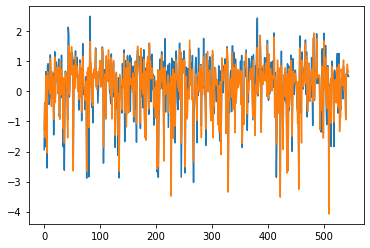

In [489]:
# Lasso 回归
from sklearn.linear_model import Lasso
model_Las=Lasso(alpha=0.0015,fit_intercept=True,normalize=False,precompute=False,copy_X=True,max_iter=1000,tol=0.0001,warm_start=False,positive=False,random_state=None,selection='cyclic')
model_Las.fit(X_train,y_train)

predict_Las=model_Las.predict(X_test)
mse_Las=mean_squared_error(y_test,predict_Las)

plt.plot(y_test)
plt.plot(predict_Las)

In [490]:
# 模型融合
predictions=[]

predictions.append(model_BR.predict(X_test))
predictions.append(model_gbdt.predict(X_test))
predictions.append(model_Las.predict(X_test))
predictions.append(model_lgb.predict(X_test))
predictions.append(model_RF.predict(X_test))
predictions.append(model_xgb.predict(X_test))

weights=[0.1,0.4,0.1,0.1,0.1,0.2]

weighted_prediction=np.average(predictions,axis=0,weights=weights)
mse_sum=mean_squared_error(y_test,weighted_prediction)

In [491]:
predictions_test=[]

predictions_test.append(model_BR.predict(test_data))
predictions_test.append(model_gbdt.predict(test_data))
predictions_test.append(model_Las.predict(test_data))
predictions_test.append(model_lgb.predict(test_data))
predictions_test.append(model_RF.predict(test_data))
predictions_test.append(model_xgb.predict(test_data))

weights=[0.1,0.2,0.1,0.2,0.2,0.2]

weighted_prediction=np.average(predictions_test,axis=0,weights=weights)


In [492]:

with open ('V3_1.txt','a+') as fp:
    for i in weighted_prediction:
        print(i,file=fp)
    fp.close
